
A1 - Preproceso de datos


En esta actividad realizaremos el preprocesado de un fichero de datos que contiene información de una
muestra de indemnizaciones otorgadas por una compañía de seguros, en función del tiempo de baja laboral
del trabajador:

Las variables del fichero de datos (train3.csv) son:

* ClaimNumber: Identificador de la póliza.
* DateTimeOfAccident: Fecha del accidente.
* DateReported: Fecha que se comunica a la compañía y se abre el expediente.
* Age: Edad del trabajador.
* Gender: Sexo.
* MaritalStatus: Estado civil, (M)arried, (S)ingle, (U)nknown, (W)idowed, (D)ivorced.
* DependentChildren: Número de hijos dependientes.
* DependentsOther: Número de dependientes excluyendo hijos.
* WeeklyWages: Salario semanal (en EUR).
* PartTimeFullTime: Jornada laboral, Part time (P) o Full time(F).
* HoursWorkedPerWeek: Número horas por semana.
* DaysWorkedPerWeek: Número de días por semana.
* ClaimDescription: Descripción siniestros.
* InitialIncurredClaimCost: Estimación inicial del coste realizado por la compañía.
* UltimateIncurredClaimCost: Coste total pagado por siniestro.



#  Carga del archivo

Cargar el archivo de datos y examinar el tipo de datos con los que R ha interpretado cada variable. Examinar
también los valores resumen de cada tipo de variable.

In [86]:
# librerias
from sklearn.impute import KNNImputer
import pandas as pd
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [87]:
# Cargamos el dataset
df_train3_raw = pd.read_csv('train3.csv',delimiter=';')

# Estilo de las graficas 'Classic'
plt.style.use('seaborn-white')

# Mostramos los primeros valores del dataset
df_train3_raw.head(2)

,ClaimNumber,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredCalimsCost,UltimateIncurredClaimCost
0,WC8285054,2002-04-09T07:00:00Z,2002-07-05T00:00:00Z,48,M,M,0,0,500,F,38,5,LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY,1500,4303.188001
1,WC6982224,1999-01-07T11:00:00Z,1999-01-20T00:00:00Z,43,F,m,0,0,"509,34",F,"37,5",5,STEPPED AROUND CRATES AND TRUCK TRAY FRACTURE ...,5500,6105.872938


In [88]:
# Mostramos los últimos valores del dataset.
# df_train3_raw.tail(2)

In [89]:
# Mostramos los tipos de datos.
df_train3_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54000 entries, 0 to 53999
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ClaimNumber                54000 non-null  object
 1   DateTimeOfAccident         54000 non-null  object
 2   DateReported               54000 non-null  object
 3   Age                        54000 non-null  int64 
 4   Gender                     54000 non-null  object
 5   MaritalStatus              53971 non-null  object
 6   DependentChildren          54000 non-null  int64 
 7   DependentsOther            54000 non-null  int64 
 8   WeeklyWages                54000 non-null  object
 9   PartTimeFullTime           54000 non-null  object
 10  HoursWorkedPerWeek         54000 non-null  object
 11  DaysWorkedPerWeek          54000 non-null  int64 
 12  ClaimDescription           54000 non-null  object
 13  InitialIncurredCalimsCost  54000 non-null  int64 
 14  Ultima

Comprobamos que el dataset tiene 54000 muestras y 15 variables. Una de las variable, MaritalStatus, contiene valores nulos. También vemos que Python hace una primera interpretacion del tipo de variables que habrá que ajustar más adelante, por ejemplo DateTimeOfAccident entre otras.

Mostramos las estadísticas básicas de las variables cuantitativas y cualitativas. Estas estadísticas nos dan una primera idea como se distribuyen las muestras.

In [90]:
# Mostramos las estadísticas básicas de las variables cuantitativas.
df_train3_raw.describe()

,Age,DependentChildren,DependentsOther,DaysWorkedPerWeek,InitialIncurredCalimsCost
count,54000.000000,54000.000000,54000.000000,54000.000000,5.400000e+04
mean,34.056093,0.119185,0.009944,4.905759,7.841146e+03
std,18.811365,0.517780,0.109348,0.552129,2.058408e+04
min,13.000000,0.000000,0.000000,1.000000,1.000000e+00
25%,23.000000,0.000000,0.000000,5.000000,7.000000e+02
50%,32.000000,0.000000,0.000000,5.000000,2.000000e+03
75%,43.000000,0.000000,0.000000,5.000000,9.500000e+03
max,999.000000,9.000000,5.000000,7.000000,2.000000e+06


In [91]:
# Mostramos las estadísticas básicas de las variables cualitativas.
df_train3_raw.describe(include=object)

,ClaimNumber,DateTimeOfAccident,DateReported,Gender,MaritalStatus,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,ClaimDescription,UltimateIncurredClaimCost
count,54000,54000,54000,54000,53971,54000,54000,54000,54000,54000
unique,53996,36673,6653,5,9,13211,2,424,28114,54000
top,WC8668542,1991-02-19T11:00:00Z,2001-03-29T00:00:00Z,M,S,200,F,38,SLIPPED ON ROLLER TENDONITIS RIGHT SHOULDER,1337.983163
freq,3,9,25,41660,26161,12372,49112,30829,289,1


Cargamos y exploramos el dataset.

Duplicamos el dataset para no modificar el original. Todos los cambios que vayamos realizando lo iremos introduciendo en el dataset final df_train.


In [92]:
df_train3 = df_train3_raw.copy()

# Duplicación de códigos

Verificad la consistencia en la variable ClaimNumber. Si existen registros duplicados, asignad un nuevo código
para evitar códigos duplicados. El nuevo código debe ser un valor no usado (valores superiores al máximo
valor numérico contenido en ClaimNumber). Conservad el mismo formato que el resto de códigos, con “WC”
delante de la secuencia numérica. Podéis usar la función duplicated de R para detectar los duplicados.

In [93]:
# Confirmamos que hay cuatro valores duplicados.
df_train3_raw["ClaimNumber"].duplicated().value_counts()

False    53996
True         4
Name: ClaimNumber, dtype: int64

In [94]:
# Comprobamos cuantos duplicados hay por valor.
ClaimNumber_counts = df_train3_raw.groupby('ClaimNumber')['ClaimNumber'].count()
ClaimNumber_counts[ClaimNumber_counts>1]

ClaimNumber
WC3501716    2
WC6383678    2
WC8668542    3
Name: ClaimNumber, dtype: int64

In [95]:
# Mostramos los valores a corregir.
df_train3_raw[df_train3_raw["ClaimNumber"].duplicated()]['ClaimNumber']

110      WC8668542
40048    WC8668542
50090    WC3501716
50278    WC6383678
Name: ClaimNumber, dtype: object

In [96]:
# Encontramos el valor más alto. 
df_train3_raw['ClaimNumber'].max()

'WC9999961'

Como solo son cuatro valores podemos modificarlos manualmente sumando uno al valor más alto. 

In [97]:
# Modificamos los valores
df_train3.loc[110,   ('ClaimNumber')] = 'WC9999962'
df_train3.loc[40048, ('ClaimNumber')] = 'WC9999963'
df_train3.loc[50090, ('ClaimNumber')] = 'WC9999964'
df_train3.loc[50278, ('ClaimNumber')] = 'WC9999965'

In [98]:
# Comprobamos que ya no hay valores duplicados.
df_train3["ClaimNumber"].duplicated().value_counts()

False    54000
Name: ClaimNumber, dtype: int64

# Nombres de las variables
Simplificad el nombre de algunas variables para hacer más fácil su manejo. En concreto, cambiad el nombre
de las variables:
    
* InitialIncurredClaimCost por IniCost
* UltimateIncurredClaimCost por UltCost
* HoursWorkedPerWeek por HoursWeek
* DaysWorkedPerWeek por DaysWeek

En el resto del enunciado, usaremos los nuevos nombres de estas variables.

In [99]:
# Modificamos los nombres de las variables y las mostramos en pantalla.
df_train3.rename(columns={'InitialIncurredCalimsCost': 'IniCost', \
                          'UltimateIncurredClaimCost': 'UltCost',\
                          'HoursWorkedPerWeek': 'HoursWeek',\
                          'DaysWorkedPerWeek': 'DaysWeek',\
                         }, inplace=True)

df_train3.loc[0:2,['HoursWeek','DaysWeek', 'IniCost', 'UltCost']]

,HoursWeek,DaysWeek,IniCost,UltCost
0,38,5,1500,4303.188001
1,"37,5",5,5500,6105.872938
2,38,5,1700,2098.629955


# Normalización de los datos cualitativos

## Marital Status
Los valores posibles en marital status son: M (married), S (single), U (unknown), D (divorced), W (widowed).
Los valores nulos corresponden a unknown. Si hay valores perdidos (vacíos), modificad estos registros vacíos
para que en su lugar aparezca U (unknown). Revisad también la consistencia del resto de valores de esta
variable.

Realizamos un primera visualizacion de los distintos valores o valores nulos y la cantidad de los mismos.

In [100]:
# Valores disponibles en la variable.
df_train3_raw.groupby(['MaritalStatus']).size()

MaritalStatus
D             63
M          21862
S          26161
U           5294
W             12
d             13
m            242
married      316
w              8
dtype: int64

In [101]:
# Cantidad de valores nulos.
df_train3_raw['MaritalStatus'].isna().value_counts()

False    53971
True        29
Name: MaritalStatus, dtype: int64

Una vez sabemos los valores a modificar ejecutamos los siguientes comandos:

In [102]:
# Cambiamo valores nulos por U (unknown)
mask = df_train3_raw['MaritalStatus'].isnull()
df_train3.loc[mask, 'MaritalStatus'] = 'U'
              
# Cambiamos d por D (divored)
mask = df_train3_raw['MaritalStatus'] =='d'
df_train3.loc[ mask, 'MaritalStatus'] = 'D'

# Cambiamos w por W (widowed).
mask = df_train3_raw['MaritalStatus'] =='w'
df_train3.loc[ mask, 'MaritalStatus'] = 'W'

# Cambiamos m y married por M (married).
mask = df_train3_raw['MaritalStatus'].str.match(r'(married)|(m)',na=False)
df_train3.loc[ mask, 'MaritalStatus'] = 'M'


Comprobamos los cambios realizados.

In [103]:
# Comprobacion de los cambions.
df_train3['MaritalStatus'].value_counts()

S    26161
M    22420
U     5323
D       76
W       20
Name: MaritalStatus, dtype: int64

## Género
Revisad la consistencia de los valores de la variable género y realizad las modificaciones oportunas.

Realizamos un primera visualizacion de los distintos valores.

In [104]:
#
df_train3_raw['Gender'].value_counts()

M     41660
F     11507
f       534
Fm      297
U         2
Name: Gender, dtype: int64

Una vez sabemos los valores a modificar ejecutamos los siguientes comandos:

In [105]:
# Cambiamos d por D (divored)
mask = df_train3_raw['Gender'] =='f'
df_train3.loc[ mask, 'Gender'] = 'F'

# Cambiamos Fm por U (unkonow), ya que Fm es un valor indeterminado.
mask = df_train3_raw['Gender'] =='Fm'
df_train3.loc[ mask, 'Gender'] = 'U'


In [106]:
# Comprobacion de los cambions.C
df_train3['Gender'].value_counts()

M    41660
F    12041
U      299
Name: Gender, dtype: int64

# Normalización de los datos cuantitativos

Inspeccionar los valores de los datos cuantitativos y realizar las normalizaciones oportunas siguiendo los criterios especificados anteriormente. Estas normalizaciones tienen como objetivo uniformizar los formatos. Si hay valores perdidos o valores extremos, se tratarán más adelante. 

Al realizar estas normalizaciones, se debe demostrar que la normalización sobre cada variable ha dado el resultado esperado. Por lo tanto, se recomienda mostrar un fragmento del archivo de datos esultante. Para evitar mostrar todo el conjunto de datos, se puede mostrar una parte del mismo, con las funciones head y/o
tail.

Seguid el orden de los apartados.

## IniCost y UltCost

Las variables InititalIncurredClaimsCost y UltimateIncurredClaimsCost se debe expresar como variables
numéricas (de tipo entero), en unidades (no en miles) y sin decimales.

In [107]:
# Mostramos los tres primeros registros a modo de ejemplo.
df_train3.loc[:,('IniCost','UltCost')].head(3)

,IniCost,UltCost
0,1500,4303.188001
1,5500,6105.872938
2,1700,2098.629955


In [108]:
# Función para normalizar variable a miles
def clean_thousand(x):
    x = str(x)
    if bool(re.search('[k|K]',x)):
        return float(re.sub('[K|k]','',x)) * 1000
    elif bool(re.search('[NA]', x)):
        return np.nan
    else:
        return float(x)

In [109]:
# Convertimos la variable a tipo int.
df_train3['IniCost'] = df_train3_raw['InitialIncurredCalimsCost'].astype(int).round(0)

In [110]:
# Convertimos la variable a tipo int y a unidades
df_train3['UltCost'] = df_train3_raw['UltimateIncurredClaimCost'].apply(clean_thousand)
df_train3['UltCost'] = df_train3['UltCost'].astype(int).round(0)

In [111]:
mask = df_train3_raw['UltimateIncurredClaimCost'].str.find('K') != -1

# Mostramos valores expresados en miles.
df_train3_raw.loc[mask, 'UltimateIncurredClaimCost']

13        1.277718363K
541      0.1077643807K
834       1.445204861K
849        8.60810336K
887       2.597486704K
             ...      
53413    0.4657165393K
53467     8.466973632K
53663     7.694874282K
53857     15.72715313K
53942     56.82290544K
Name: UltimateIncurredClaimCost, Length: 324, dtype: object

In [112]:
# Mismos valores expresados en unidades despues del processado.
df_train3.loc[mask, 'UltCost']

13        1277
541        107
834       1445
849       8608
887       2597
         ...  
53413      465
53467     8466
53663     7694
53857    15727
53942    56822
Name: UltCost, Length: 324, dtype: int64

In [113]:
# Resultado final.
df_train3.loc[:,('IniCost','UltCost')].head(3)

,IniCost,UltCost
0,1500,4303
1,5500,6105
2,1700,2098


## Edad

Las variables Age y DaysWorkedPerWeek deben ser de tipo entero, sin decimales.

In [114]:
df_train3['Age'] = df_train3_raw['Age'].astype(int).round(0)

In [115]:
df_train3['DaysWorkedPerWeek'] = df_train3_raw['DaysWorkedPerWeek'].astype(int).round(0)

## WeeklyWages, HoursWeek, DaysWeek

Revisad el formato de estas variables y realizad las transformaciones oportunas según los criterios especificados anteriormente. Visualizad la distribución de los valores en estas tres variables, usando el tipo de gráfico adecuado. Si existen valores extremos, se tratarán más adelante.

Las variables WeeklyWages y HoursWorkedPerWeek deben expresarse como variables numéricas y si es necesario, con decimales.

In [116]:
# Mostramos los tres primeros registros a modo de ejemplo.
df_train3_raw.loc[:, ('WeeklyWages','HoursWorkedPerWeek','DaysWorkedPerWeek')].head(3)

,WeeklyWages,HoursWorkedPerWeek,DaysWorkedPerWeek
0,500,38,5
1,"509,34","37,5",5
2,"709,1",38,5


In [117]:
# Función para reemplazamos el coma por el punto.
def coma_to_point(x):
    x = str(x)
    return x.replace(',','.')

In [118]:
# Cambio del tipo de dato.
df_train3['WeeklyWages'] = df_train3_raw['WeeklyWages'].apply(coma_to_point).astype(float)
df_train3['HoursWeek'] = df_train3_raw['HoursWorkedPerWeek'].apply(coma_to_point).astype(float)
df_train3['DaysWeek'] = df_train3_raw['DaysWorkedPerWeek'].apply(coma_to_point).astype(int).round(0)

In [119]:
# Mostramos el resultado.
df_train3.loc[:, ('WeeklyWages','HoursWeek','DaysWeek')].head(3)

,WeeklyWages,HoursWeek,DaysWeek
0,500.00,38.0,5
1,509.34,37.5,5
2,709.10,38.0,5


Visualizamos un histograma de cada una de las variables. Vemos que para las variables WeeklyWages y HoursWeek existen valores atípicos que hacen perder el foco en los datos relevantes.

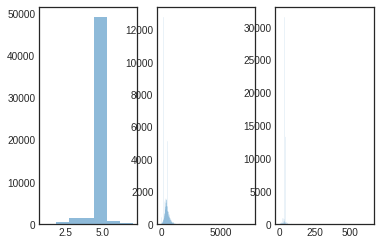

In [120]:
# Visualizacion histogramas.
plt.subplot(1,3,1)
plt.hist(df_train3['DaysWeek'], alpha =0.5, histtype='stepfilled', bins=7)
plt.subplot(1,3,2)
plt.hist(df_train3['WeeklyWages'], alpha =0.5, histtype='stepfilled', bins=500)
plt.subplot(1,3,3)
plt.hist(df_train3['HoursWeek'], alpha =0.5, histtype='stepfilled', bins=500)
plt.show()
plt.show()

# Valores atípicos
Revisad si hay valores atípicos en las variables Age y HoursWeek. Si se trata de un valor anómalo, es decir normalmente alto o bajo, substituir su valor por NA y posteriormente se imputará.

En la figura inferior podemos ves los valores que exceden los bigotes del diagrama de caja.

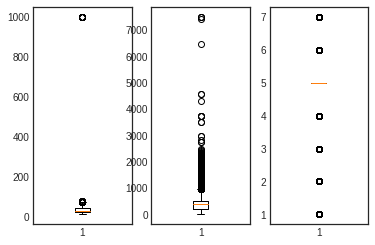

In [121]:
fig = plt.figure()

# Mostramos el box plot de las tres variables
ax = fig.add_subplot(1,3,1)
ax.boxplot(df_train3['Age'])
ax = fig.add_subplot(1,3,2)
ax.boxplot(df_train3['WeeklyWages'])
ax = fig.add_subplot(1,3,3)
ax.boxplot(df_train3['DaysWeek'])
plt.show()

## Age

In [122]:
# Cuartiles.
a = df_train3['Age'].quantile([0.25, 0.5, 0.75])
print(a)

0.25    23.0
0.50    32.0
0.75    43.0
Name: Age, dtype: float64


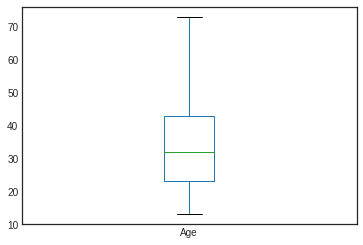

In [123]:
# Cuartiles.
quartiles = np.percentile(df_train3['Age'], [25, 50, 75])

# IQR
Ls = quartiles[2] + (quartiles[2]-quartiles[0]) * 1.5 
Li = quartiles[0] - (quartiles[2]-quartiles[0]) * 1.5

# Reemplazamos los valores por NA
df_train3.loc[df_train3['Age'] > Ls, 'Age'] = np.nan
df_train3.loc[df_train3['Age'] < Li, 'Age'] = np.nan

df_train3['Age'].plot.box()
plt.show()

## HoursWeek

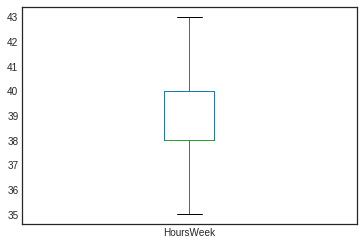

In [124]:
# Quartiles
quartiles = np.percentile(df_train3['HoursWeek'],[25, 50, 75])

# IQR
Ls = quartiles[2] + (quartiles[2]-quartiles[0]) * 1.5 
Li = quartiles[0] - (quartiles[2]-quartiles[0]) * 1.5

# Reemplazamos los valores por NA
df_train3.loc[df_train3['HoursWeek'] > Ls, 'HoursWeek'] = np.nan
df_train3.loc[df_train3['HoursWeek'] < Li, 'HoursWeek'] = np.nan

# Mostramos el resultado sin outliers
df_train3['HoursWeek'].plot.box()
plt.show()

Una vez que hemos 'eliminados' los valores atipicos reemplazandolos por el valor NA, podemos observar como ya no hay valores por encima de los bigores de la caja 

# Imputación de valores
Buscad si existen valores perdidos en las variables cuantitativas Age, WeeklyWages, HoursWeek, IniCost y UltCost.

En caso de valores perdidos, aplicad el proceso siguiente:

Comprobamos que solo la variable Age y HoursWeek contienen valores nulos. Procedemos a imputarlos.

In [125]:
# Comprobamos las variables con valores nulos.
df_train3.isnull().sum()
df_train3.isna().sum()

ClaimNumber              0
DateTimeOfAccident       0
DateReported             0
Age                     34
Gender                   0
MaritalStatus            0
DependentChildren        0
DependentsOther          0
WeeklyWages              0
PartTimeFullTime         0
HoursWeek             7446
DaysWeek                 0
ClaimDescription         0
IniCost                  0
UltCost                  0
DaysWorkedPerWeek        0
dtype: int64

## Age

* Para Age, aplicad imputación por la media aritmética.

In [126]:
# Media.
def my_mean(serie):
    return np.true_divide(serie.sum(),len(serie))

In [127]:
print('Media antes the de la imputación {:.4f}'.format(my_mean(df_train3['Age'])))

Media antes the de la imputación 33.8031


In [128]:
# Imputamos los valores nulos con la funcion propria de la media.
mask = df_train3['Age'].isna()
df_train3.loc[mask, 'Age'] = my_mean(df_train3['Age'])

In [129]:
print('Media despues the de la imputación {:.4f}'.format(my_mean(df_train3['Age'])))

Media despues the de la imputación 33.8244


La variacion de la media Age no varia significativamente. Esta variación minima tiene sentido si vemos el número total de valores nulos con respecto al total.  

## HoursWeek

* En el resto de variables, aplicad imputación por vecinos más cercanos, usando la distancia de Gower, considerando en el cómputo de los vecinos más cercanos el resto de variables cuantitativas mencionadas en este apartado. Además, considerad que la imputación debe hacerse con registros del mismo género. Per exemple, si un registro a imputar es de género "M", se debe realizar la imputación usando las variables cuantitativas de los registros de género "M". Para realizar esta imputación, podéis usar la función "kNN" de la librería VIM.

In [130]:
print('Media antes de de la imputación {:.4f}'.format(my_mean(df_train3['HoursWeek'])))

Media antes de de la imputación 33.2232


La imputación debe hacerse teniendo en cuenta la variable 'Gender' por lo que subdividimos el dataset en tres sub-datasets: M, F y U. 

In [131]:
# Agrupamos por genger
df_train3['Gender'].value_counts()

M    41660
F    12041
U      299
Name: Gender, dtype: int64

## Male

Creamos un dataset teniendo en cuenta la variable 'Male' y ejecutamos la imputacion por KNN.

In [132]:
# Dataframe para realizar la imputación KNN sobre el genero masculino.
df_m = df_train3.loc[df_train3['Gender'] == 'M', ('Age', 'WeeklyWages', 'HoursWeek', 'IniCost', 'UltCost')]
# Contamos los valores nulos.
df_m['HoursWeek'].isna().value_counts()

False    37648
True      4012
Name: HoursWeek, dtype: int64

In [133]:
# Applicamos KNN
imputer = KNNImputer(n_neighbors=5)
m_imputed = imputer.fit_transform(df_m)

Obtenemos un sub-dataset con los valores nulos imputados.

In [134]:
df_m_imputed = pd.DataFrame(m_imputed, columns = ['Age', 'WeeklyWages', 'HoursWeek', 'IniCost', 'UltCost'], index = df_m.index)

## Female

Creamos un dataset teniendo en cuenta la variable 'Female' y ejecutamos la imputacion por KNN.

In [135]:
# Dataframe para realizar la imputación KNN sobre el genero femenino.
df_f = df_train3.loc[df_train3['Gender'] == 'F', ('Age', 'WeeklyWages', 'HoursWeek', 'IniCost', 'UltCost')]
# Contamos los valores nulos.
df_f['HoursWeek'].isna().value_counts()

False    8693
True     3348
Name: HoursWeek, dtype: int64

In [136]:
# Applicamos KNN
imputer = KNNImputer(n_neighbors=5)
f_imputed = imputer.fit_transform(df_f)

Obtenemos un sub-dataset con los valores nulos imputados.

In [137]:
df_f_imputed = pd.DataFrame(f_imputed, columns = ['Age', 'WeeklyWages', 'HoursWeek', 'IniCost', 'UltCost'], index = df_f.index)

## Undefined

Creamos un dataset teniendo en cuenta la variable 'Indefinido' y ejecutamos la imputacion por KNN.

In [138]:
# Dataframe para realizar la imputación KNN sobre el genero indefinido.
df_u = df_train3.loc[df_train3['Gender'] == 'U', ('Age', 'WeeklyWages', 'HoursWeek', 'IniCost', 'UltCost')]
# Contamos los valores nulos.
df_u['HoursWeek'].isna().value_counts()

False    213
True      86
Name: HoursWeek, dtype: int64

In [139]:
# Applicamos KNN
imputer = KNNImputer(n_neighbors=5)
u_imputed = imputer.fit_transform(df_u)

Obtenemos un sub-dataset con los valores nulos imputados.

In [140]:

df_u_imputed = pd.DataFrame(u_imputed, columns = ['Age', 'WeeklyWages', 'HoursWeek', 'IniCost', 'UltCost'], index = df_u.index)

## Concatenación de los sub-dataset

Concatenamos los tres dataset en un solo y añadimos el dataset resultante al dataset originasl df_train3.

In [141]:
# Concatenación.
HoursWeek = pd.concat([df_f_imputed['HoursWeek'],df_m_imputed['HoursWeek'], df_u_imputed['HoursWeek']])

Para tener la certeza que solo los valores nulos han sido modificados comparamos el dataset original y el modificado con las imputaciones. Vemos que la imputación se ha realizado correctamente, ya que el numero total de valores modificados es el mismo que el numero de valores nulos inicial.

In [142]:
# df_train3['HoursWeek'] es el dataset orifinal y HoursWeek el nuevo dataset con las imputaciones.
mask = df_train3['HoursWeek'].sort_index() == HoursWeek.sort_index()

In [143]:
mask.value_counts()

True     46554
False     7446
Name: HoursWeek, dtype: int64

Copiamos los nuevos valores al dataset original.

In [144]:
# Reemplazamos los valores iniciales.
df_train3['HoursWeek'] = HoursWeek

La variacion de la media varia significativamente. Esta variación tiene sentido si vemos el número total de valores nulos con respecto al total.

In [145]:
print('Media después de de la imputación {:.4f}'.format(df_train3['HoursWeek'].mean()))

Media después de de la imputación 38.5324


In [146]:
# Comprobamoslas variables con valores nulos.
df_train3.isnull().sum()
df_train3.isna().sum()

ClaimNumber           0
DateTimeOfAccident    0
DateReported          0
Age                   0
Gender                0
MaritalStatus         0
DependentChildren     0
DependentsOther       0
WeeklyWages           0
PartTimeFullTime      0
HoursWeek             0
DaysWeek              0
ClaimDescription      0
IniCost               0
UltCost               0
DaysWorkedPerWeek     0
dtype: int64

# Preparación de los datos

## Tiempo de abertura del expediente
Calculad el tiempo que se tarda en abrir el expediente desde el suceso del accidente, a partir de las variables DateOfTimeAccident y DateReported. Para ello, debéis convertir las variables en formato fecha (Date) y realizar posteriormente el cálculo. Guardad la información en una variable Time del conjunto de datos.


In [147]:
# Convertimos las variables a Datetime.
df_train3_raw['DateTimeOfAccident'] = pd.to_datetime(df_train3_raw['DateTimeOfAccident'])
df_train3_raw['DateReported'] = pd.to_datetime(df_train3_raw['DateReported'])

In [148]:
# Calculad el tiempo que se tarda en abrir el expediente desde el suceso del accidente.
df_train3['Time'] = df_train3_raw['DateReported'] - df_train3_raw['DateTimeOfAccident']
df_train3['Time'] = df_train3['Time'].dt.days

In [149]:
# Mostramos la nueva variable Time.
df_train3['Time'].head(3)

0    86
1    12
2    20
Name: Time, dtype: int64

## Diferencia entre IniCost y UltCost
Calculad la diferencia entre el coste final y el coste inicial estimado. Añadid una variable “DifCost” al conjunto de datos y visualizad su distribución con un gráfico adecuado.

In [150]:
# Calculo entre el coste final y el coste inicial estimado. 
df_train3['DifCost'] = df_train3['UltCost'] - df_train3['IniCost']

Ya que los outliers no permiten una visualización correcta de la distribucion, eliminamos los valores atipicos.

In [151]:
df_train3_tmp = df_train3.copy()

# Quartiles
quartiles = np.percentile(df_train3['DifCost'],[25, 50, 75])

# IQR
Ls = quartiles[2] + (quartiles[2]-quartiles[0]) * 1.5 
Li = quartiles[0] - (quartiles[2]-quartiles[0]) * 1.5

# Reemplazamos los valores por NA
df_train3_tmp.loc[df_train3['DifCost'] > Ls, 'DifCost'] = np.nan
df_train3_tmp.loc[df_train3['DifCost'] < Li, 'DifCost'] = np.nan

Text(0.5, 0, 'Diferencia entre el coste final y el coste inicial estimado')

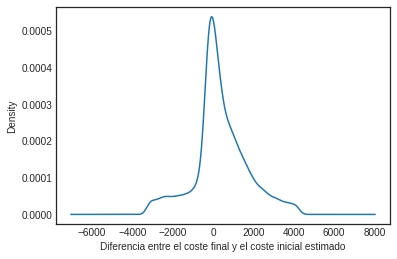

In [152]:
# Mostramos su desidad
ax = df_train3_tmp['DifCost'].plot.density()
ax.set_xlabel('Diferencia entre el coste final y el coste inicial estimado')

Presenta una distribucion centrada en cero siendo el lado derecho más proninciado (skewed).

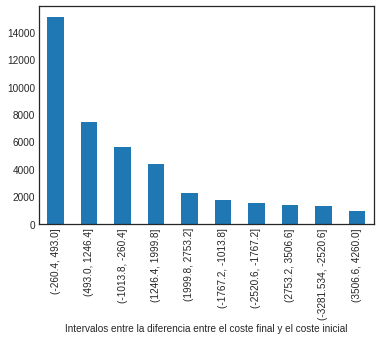

In [153]:
# Mostramos el histograma.
binnedDifCost = pd.cut(df_train3_tmp['DifCost'],10)
ax = binnedDifCost.value_counts().plot.bar()
ax.set_xlabel('Intervalos entre la diferencia entre el coste final y el coste inicial')
plt.show()

Observamos que la mayoria de las muestras se encuentra en el primer bin entre los valores -260.4 y 493.0.

# Estudio descriptivo

## Funciones de media robustas

Implementad una función, dado un vector con datos numéricos, calcule la media recortada y la media Winsor. Estas funciones se deben definir como sigue:

media.recortada <- function( x, perc=0.05){}

media.winsor( x, perc=0.05){}

donde x es el vector de datos y perc la fracción de los datos a recortar (por defecto, 0.05). Comprobad que funcionan correctamente.


## Funciones propias.

In [154]:
# Media recortada.
def recortada(serie, percentage):
        serie_sorted = np.sort(serie)
        position = percentage * len(serie_sorted) 
        #print('Trimmed at position: {}'.format(position))
        if 0 < percentage and percentage < 0.5:
            serie_trimmed = serie_sorted[int(np.floor(position)):-int(np.ceil(position))]
            return 'Media recortada al {}% {:.2f}'.format(percentage*100 ,my_mean(serie_trimmed))                                                               
        else:
            print('ERROR: percentage not between 0 < x > 0.5')
            
# Media Winsor.
def my_winsor(serie, percentage):
        serie_sorted = np.sort(serie)
        position = percentage * len(serie_sorted) 
        #print('Trimmed at position: {}'.format(position))
        if 0 < percentage and percentage < 0.5:
            serie_sorted[-int(np.floor(position)):] = serie_sorted[-int(np.floor(position+1))]
            serie_sorted[:int(np.ceil(position))] = serie_sorted[int(np.floor(position))]
            #print(serie_sorted)
            return 'Media Winsor al {}% {:.2f}'.format(percentage*100 ,my_mean(serie_sorted))                                                               
        else:
            print('ERROR: percentage not between 0 < x > 0.5')

## Comprobación de las funciones propias.


In [155]:
# Funcion propia Recortada.
print(recortada(df_train3['DifCost'], .05))

Media recortada al 5.0% 441.93


Comprobamos que la media recortada es igual cuando usamos un funcion propia de Python.

In [156]:
from scipy.stats import trim_mean

# Funcion de una libreria de python.
print(trim_mean(df_train3['DifCost'], .05))

441.9279012345679


Comprobamos la media Winsor del la variable DifCost y con un array simple que va del 1 al 10 para ver su resultado más facilmente.

In [157]:
# Función propia Winsor.
my_winsor(df_train3['DifCost'], .05)

'Media Winsor al 5.0% 761.64'

In [158]:
# Array del 1 al 10
i = np.arange(10)
print(i)

# Ejecutamos nuestra función propia de la media winsor.
my_winsor(i, .2)


[0 1 2 3 4 5 6 7 8 9]


'Media Winsor al 20.0% 4.50'

[2 2 2 3 4 5 6 7 7 7]

In [159]:
# Importamos la libreria necesaria.
from scipy.stats import trim_mean

# Ejecutamos la funcion de media recortada.
print(trim_mean(df_train3['DifCost'], .05))

441.9279012345679


## Estudio descriptivo de las variables cuantitativas

Realizad un estudio descriptivo de las variables cuantitativas Age, WeeklyWages, DaysWeek, HoursWeek, IniCost, UltCost. Para ello, preparad una tabla con varias medidas de tedencia central y dispersión, robustas y no robustas. Usad, entre otras, las funciones del apartado anterior. Presentad, asimismo gráficos donde se visualice la distribución de los valores de estas variables cuantitativas.

In [160]:
# Variables.
var = ['Age', 'WeeklyWages', 'DaysWeek', 'HoursWeek', 'IniCost', 'UltCost']

## Tedencia central

In [161]:
for i in var:
    print('Medidas de tedencia central para la variable {}: \n\t Media {:.2f} \n\t {} \n\t {} \n\t Mediana {} \n\t Percentiles {}'
          .format(i, 
                  np.mean(df_train3[i])
                  , my_winsor(df_train3[i], 0.05)
                  , recortada(df_train3[i], 0.05)
                  , np.median(df_train3[i])
                  , np.percentile(df_train3[i],[25, 50, 75])))

Medidas de tedencia central para la variable Age: 
	 Media 33.82 
	 Media Winsor al 5.0% 33.68 
	 Media recortada al 5.0% 33.31 
	 Mediana 32.0 
	 Percentiles [23. 32. 43.]
Medidas de tedencia central para la variable WeeklyWages: 
	 Media 416.36 
	 Media Winsor al 5.0% 406.01 
	 Media recortada al 5.0% 394.62 
	 Mediana 392.2 
	 Percentiles [200.  392.2 500. ]
Medidas de tedencia central para la variable DaysWeek: 
	 Media 4.91 
	 Media Winsor al 5.0% 4.93 
	 Media recortada al 5.0% 4.98 
	 Mediana 5.0 
	 Percentiles [5. 5. 5.]
Medidas de tedencia central para la variable HoursWeek: 
	 Media 38.53 
	 Media Winsor al 5.0% 38.58 
	 Media recortada al 5.0% 38.54 
	 Mediana 38.0 
	 Percentiles [38. 38. 40.]
Medidas de tedencia central para la variable IniCost: 
	 Media 7841.15 
	 Media Winsor al 5.0% 6108.34 
	 Media recortada al 5.0% 5102.87 
	 Mediana 2000.0 
	 Percentiles [ 700. 2000. 9500.]
Medidas de tedencia central para la variable UltCost: 
	 Media 10194.96 
	 Media Winsor al 5.0%

En el paso anterior podemos observar differentes cálculo de tendencia central. El primero, mediante la media el cual produce el valor más alto de todos. Esto se debe a que el valor de la media se ve influenciado por los valores extremos minimos y maximos. También observamos como la imputacion de los valores extremos con el método Winsor o mediante la media recortada, eliminando los valores extremos, afecta al valor central disminuyendo considerablemente. Por último observamos la dispersion de las muestras mediante el IQR que define los valores de la variables en los que engloba el 50% de las muestras (desde el percentil 25 al 75). IQR tambien nos permite hacer una primera valoración del tipo de distribución y si está esta desplazada a uno de los lados (skewed).

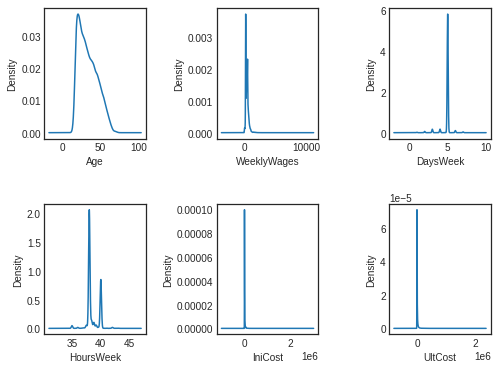

In [162]:
# Variables a analizar.
var = ['Age', 'WeeklyWages', 'DaysWeek', 'HoursWeek', 'IniCost', 'UltCost']

# Visualizaciones.
fig = plt.figure(figsize=(8, 6))
fig.subplots_adjust(hspace=0.5, wspace=0.7)
# Age
ax = fig.add_subplot(2,3,1)
ax = df_train3['Age'].plot.density()
ax.set_xlabel('Age')
# WeeklyWages
ax = fig.add_subplot(2,3,2)
ax = df_train3['WeeklyWages'].plot.density()
ax.set_xlabel('WeeklyWages')
# DaysWeek
ax = fig.add_subplot(2,3,3)
ax = df_train3['DaysWeek'].plot.density()
ax.set_xlabel('DaysWeek')
# HoursWeek
ax = fig.add_subplot(2,3,4)
ax = df_train3['HoursWeek'].plot.density()
ax.set_xlabel('HoursWeek')
# IniCost
ax = fig.add_subplot(2,3,5)
ax = df_train3['IniCost'].plot.density()
ax.set_xlabel('IniCost')
# UltCost
ax = fig.add_subplot(2,3,6)
ax = df_train3['UltCost'].plot.density()
ax.set_xlabel('UltCost')

plt.show()

# Archivo final
Archivo final
Una vez realizado el preprocesamiento sobre el archivo, copiad el resultado de los datos en un archivo llamado
“train_clean.csv”.

In [163]:
df_train3.to_csv(path_or_buf='Segovia_vilchez_clean.csv',sep=',')